# Before your start:
- Read the README.md file
- Comment as much as you can and use the resources in the README.md file
- Happy learning!

In [1]:
# Import your libraries:

%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Challenge 1 - Import and Describe the Dataset

In this lab, we will use a dataset containing information about customer preferences. We will look at how much each customer spends in a year on each subcategory in the grocery store and try to find similarities using clustering.

The origin of the dataset is [here](https://archive.ics.uci.edu/ml/datasets/wholesale+customers).

In [2]:
# loading the data:
customers = pd.read_csv('../Wholesale customers data.csv')

#### Explore the dataset with mathematical and visualization techniques. What do you find?

Checklist:

* What does each column mean?
* Any categorical data to convert?
* Any missing data to remove?
* Column collinearity - any high correlations?
* Descriptive statistics - any outliers to remove?
* Column-wise data distribution - is the distribution skewed?
* Etc.

Additional info: Over a century ago, an Italian economist named Vilfredo Pareto discovered that roughly 20% of the customers account for 80% of the typical retail sales. This is called the [Pareto principle](https://en.wikipedia.org/wiki/Pareto_principle). Check if this dataset displays this characteristic.

In [238]:
# Your code here:

#* What does each column mean?
#1) FRESH: annual spending (m.u.) on fresh products (Continuous);
#2) MILK: annual spending (m.u.) on milk products (Continuous);
#3) GROCERY: annual spending (m.u.)on grocery products (Continuous);
#4) FROZEN: annual spending (m.u.)on frozen products (Continuous)
#5) DETERGENTS_PAPER: annual spending (m.u.) on detergents and paper products (Continuous)
#6) DELICATESSEN: annual spending (m.u.)on and delicatessen products (Continuous);
#7) CHANNEL: customersâ€™ Channel - Horeca (Hotel/Restaurant/CafÃ©) or Retail channel (Nominal)
#8) REGION: customersâ€™ Region â€“ Lisnon, Oporto or Other (Nomina

customers.head()



,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [239]:
customers.dtypes
### types ok

Channel             int64
Region              int64
Fresh               int64
Milk                int64
Grocery             int64
Frozen              int64
Detergents_Paper    int64
Delicassen          int64
dtype: object

In [240]:
#* Any categorical data to convert?

customers.Channel.value_counts()
customers.Region.value_counts()

#### two categorical variables but since they are nummercial we dont need to  convert in dummies, ?
customers_d = pd.get_dummies(customers, columns=['Channel', 'Region'], drop_first=True)
customers_d
# i am not sure, if we need dummies, when the categorical variables are nummerical.

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Channel_2,Region_2,Region_3
0,12669,9656,7561,214,2674,1338,1,0,1
1,7057,9810,9568,1762,3293,1776,1,0,1
2,6353,8808,7684,2405,3516,7844,1,0,1
3,13265,1196,4221,6404,507,1788,0,0,1
4,22615,5410,7198,3915,1777,5185,1,0,1
...,...,...,...,...,...,...,...,...,...
435,29703,12051,16027,13135,182,2204,0,0,1
436,39228,1431,764,4510,93,2346,0,0,1
437,14531,15488,30243,437,14841,1867,1,0,1
438,10290,1981,2232,1038,168,2125,0,0,1


In [241]:
## * Any missing data to remove?
customers_d.isna().sum()

## nope

Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicassen          0
Channel_2           0
Region_2            0
Region_3            0
dtype: int64

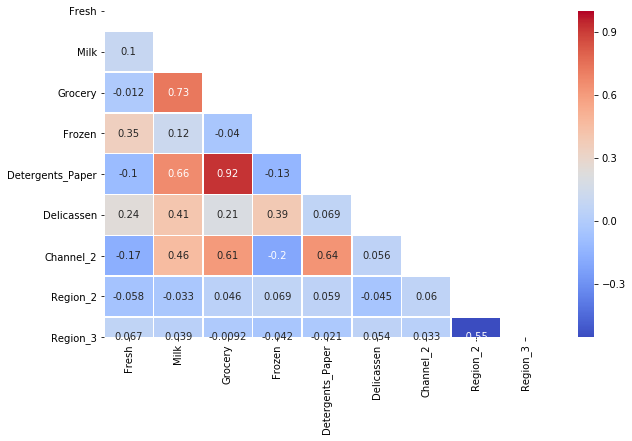

In [242]:
##* Column collinearity - any high correlations?
import seaborn as sns
plt.figure(figsize =(10,6))
corr = customers_d.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
sns.heatmap(corr, cmap='coolwarm', annot = True, linewidth=0.5, mask=mask)

In [243]:
#Grocery and Detergents_Paper are colinear --> drop Detergents_paper

customers_d.drop('Detergents_Paper', axis =1, inplace=True) 



In [244]:
## * Descriptive statistics - any outliers to remove?
customers_d.describe()


## yes there are in all the non-categorical columsn

Q1 = customers_d.quantile(0.25)
Q3 = customers_d.quantile(0.75)
IQR = Q3 - Q1

customers_d_out = customers_d[~((customers_d < (Q1 - 1.5 * IQR)) |(customers_d> (Q3 + 1.5 * IQR))).any(axis=1)]
customers_d.shape[0]-customers_d_out.shape[0]
### droped too many ---> keep the outliers

135

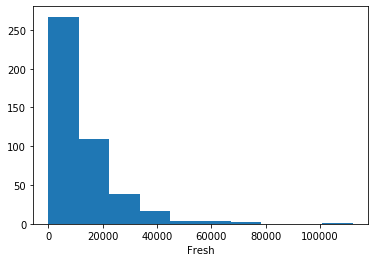

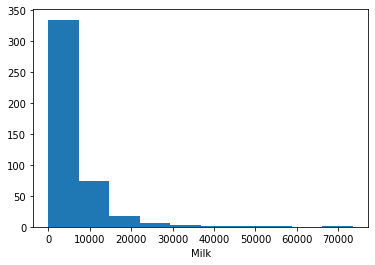

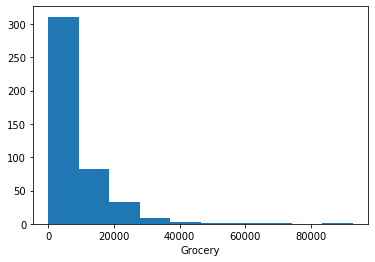

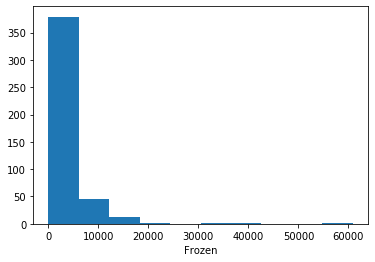

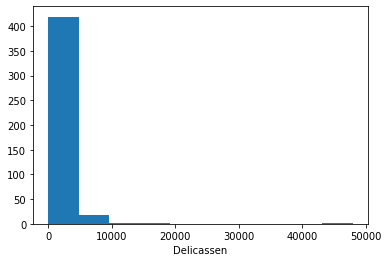

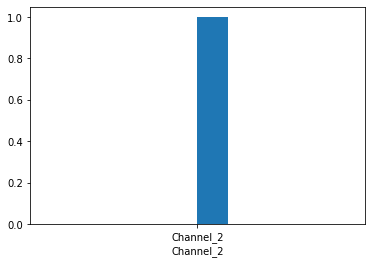

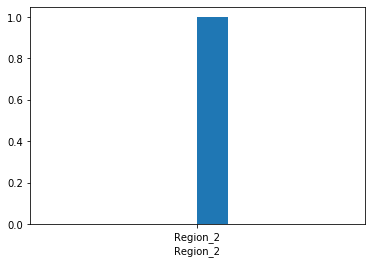

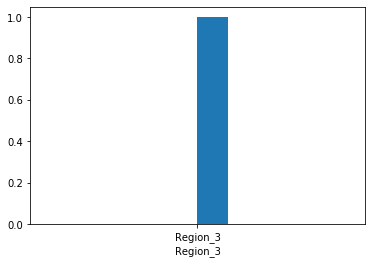

In [245]:
##* Column-wise data distribution - is the distribution skewed?
for f in customers_d.describe():
    plt.hist(f, data = customers)
    plt.xlabel(f)
    plt.show()
    


## the distribution is veryl left skewed


# Challenge 2 - Data Cleaning and Transformation

If your conclusion from the previous challenge is the data need cleaning/transformation, do it in the cells below. However, if your conclusion is the data need not be cleaned or transformed, feel free to skip this challenge. But if you do choose the latter, please provide rationale.

In [246]:
# Your code here
## see above

In [247]:
# Your comment here

## after plotting in challenge 6 i decide to drop outliers, but based on quantile 0.9

Q1 = customers_d.quantile(0.1)
Q3 = customers_d.quantile(0.9)
IQR = Q3 - Q1

customers_d_out = customers_d[~((customers_d < (Q1 - 1.5 * IQR)) |(customers_d> (Q3 + 1.5 * IQR))).any(axis=1)]
customers_d.shape[0]-customers_d_out.shape[0]
### droped too many ---> keep the outliers
customers_d=customers_d_out
#Q3+1.5*IQR

# Challenge 3 - Data Preprocessing

One problem with the dataset is the value ranges are remarkably different across various categories (e.g. `Fresh` and `Grocery` compared to `Detergents_Paper` and `Delicassen`). If you made this observation in the first challenge, you've done a great job! This means you not only completed the bonus questions in the previous Supervised Learning lab but also researched deep into [*feature scaling*](https://en.wikipedia.org/wiki/Feature_scaling). Keep on the good work!

Diverse value ranges in different features could cause issues in our clustering. The way to reduce the problem is through feature scaling. We'll use this technique again with this dataset.

#### We will use the `StandardScaler` from `sklearn.preprocessing` and scale our data. Read more about `StandardScaler` [here](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler).

*After scaling your data, assign the transformed data to a new variable `customers_scale`.*

In [248]:
# Your import here:

from sklearn.preprocessing import StandardScaler

# Your code here:


scaler = StandardScaler()
customers_scale = scaler.fit_transform(customers_d)


# Challenge 4 - Data Clustering with K-Means

Now let's cluster the data with K-Means first. Initiate the K-Means model, then fit your scaled data. In the data returned from the `.fit` method, there is an attribute called `labels_` which is the cluster number assigned to each data record. What you can do is to assign these labels back to `customers` in a new column called `customers['labels']`. Then you'll see the cluster results of the original data.

In [251]:
# Your code here:
# Create k-mean object
from sklearn.cluster import KMeans
#n_clusters = 5
cluster = KMeans(random_state=0, n_jobs=-1)#n_clusters=n_clusters,

# Train model
model = cluster.fit(customers_scale)

customers_d['labels'] = cluster.labels_



customers_d.head()

C:\Users\haenni\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


,Fresh,Milk,Grocery,Frozen,Delicassen,Channel_2,Region_2,Region_3,labels
0,12669,9656,7561,214,1338,1,0,1,3
1,7057,9810,9568,1762,1776,1,0,1,3
3,13265,1196,4221,6404,1788,0,0,1,4
4,22615,5410,7198,3915,5185,1,0,1,0
5,9413,8259,5126,666,1451,1,0,1,3


Count the values in `labels`.

In [252]:
# Your code here:
customers_d['labels'].value_counts()

1    137
3     89
5     52
2     38
4     29
6     28
7     25
0     24
Name: labels, dtype: int64

# Challenge 5 - Data Clustering with DBSCAN

Now let's cluster the data using DBSCAN. Use `DBSCAN(eps=0.5)` to initiate the model, then fit your scaled data. In the data returned from the `.fit` method, assign the `labels_` back to `customers['labels_DBSCAN']`. Now your original data have two labels, one from K-Means and the other from DBSCAN.

In [254]:
# Your code here
from sklearn.cluster import DBSCAN

# Create meanshift object
cluster = DBSCAN(eps=0.5)

# Train model
model = cluster.fit(customers_scale)

customers_d['labels_DBSCAN'] = cluster.labels_


customers_d.head()

C:\Users\haenni\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


,Fresh,Milk,Grocery,Frozen,Delicassen,Channel_2,Region_2,Region_3,labels,labels_DBSCAN
0,12669,9656,7561,214,1338,1,0,1,3,-1
1,7057,9810,9568,1762,1776,1,0,1,3,-1
3,13265,1196,4221,6404,1788,0,0,1,4,-1
4,22615,5410,7198,3915,5185,1,0,1,0,-1
5,9413,8259,5126,666,1451,1,0,1,3,-1


Count the values in `labels_DBSCAN`.

In [255]:
# Your code here
customers_d['labels_DBSCAN'].value_counts()

-1    329
 0     81
 2      7
 1      5
Name: labels_DBSCAN, dtype: int64

# Challenge 6 - Compare K-Means with DBSCAN

Now we want to visually compare how K-Means and DBSCAN have clustered our data. We will create scatter plots for several columns. For each of the following column pairs, plot a scatter plot using `labels` and another using `labels_DBSCAN`. Put them side by side to compare. Which clustering algorithm makes better sense?

Columns to visualize:

* `Detergents_Paper` as X and `Milk` as y
* `Grocery` as X and `Fresh` as y
* `Frozen` as X and `Delicassen` as y

Visualize `Detergents_Paper` as X and `Milk` as y by `labels` and `labels_DBSCAN` respectively

In [258]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

def plotcompare(a,b):

    f = plt.figure(figsize=(12,6))
    ax = f.add_subplot(121)
    ax2 = f.add_subplot(122)

    #ax KMeans
    ax.title.set_text('KMeans')
    ax.scatter(customers_d[a], customers_d[b], c=customers_d['labels'])
    ax.set_xlabel(a)
    ax.set_ylabel(b)


    #ax2 DBSCAN
    ax2.title.set_text('DBSCAN')
    ax2.scatter(customers_d[a], customers_d[b],c=customers_d['labels_DBSCAN'])
    ax2.set_xlabel(a)
    ax2.set_ylabel(b)

    plt.show()
    
#plotcompare('Detergents_Paper', 'Milk') ... i droped 'Detergents_Paper' 

Visualize `Grocery` as X and `Fresh` as y by `labels` and `labels_DBSCAN` respectively

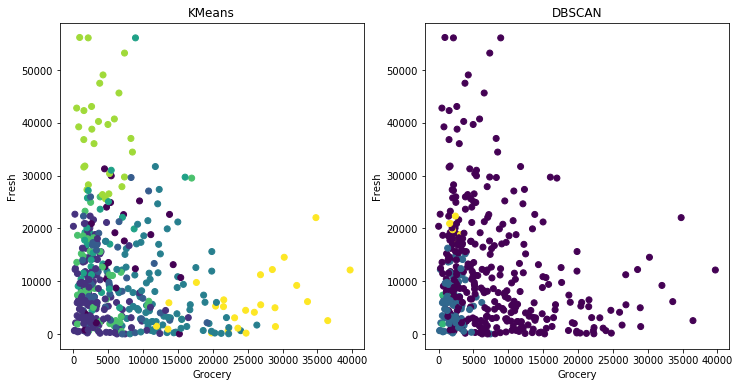

In [259]:
# Your code here:

plotcompare('Grocery', 'Fresh')

Visualize `Frozen` as X and `Delicassen` as y by `labels` and `labels_DBSCAN` respectively

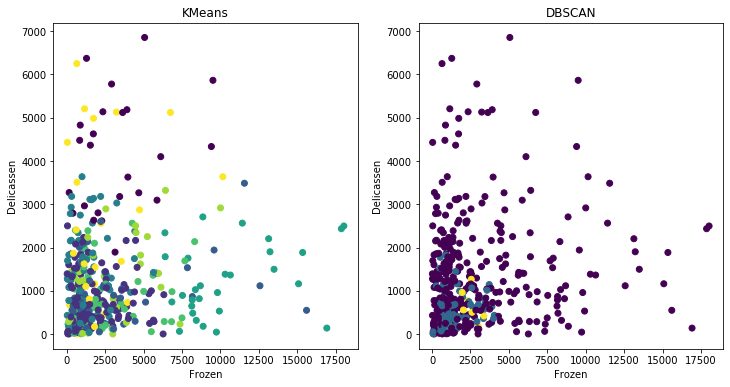

In [260]:
# Your code here:
plotcompare('Frozen', 'Delicassen')

Let's use a groupby to see how the mean differs between the groups. Group `customers` by `labels` and `labels_DBSCAN` respectively and compute the means for all columns.

In [270]:
# Your code here:
customers_d.groupby(['labels']).mean()

,Fresh,Milk,Grocery,Frozen,Delicassen,Channel_2,Region_2,Region_3,labels_DBSCAN
labels,,,,,,,,,
0,14741.541667,7100.250000,6880.791667,3252.458333,4132.458333,0.125000,0.00,0.833333,-1.000000
1,7621.408759,2418.562044,3144.094891,1733.854015,735.744526,0.000000,0.00,1.000000,-0.255474
2,10214.421053,2846.000000,5674.552632,3167.815789,960.947368,0.289474,1.00,0.000000,-1.000000
3,7844.730337,7709.089888,12487.730337,1256.449438,1303.775281,1.000000,0.00,0.921348,-1.000000
4,17634.517241,4255.241379,4144.000000,10469.689655,1250.068966,0.034483,0.00,0.965517,-1.000000
5,9118.019231,3154.326923,3794.730769,2489.576923,854.211538,0.057692,0.00,0.000000,-0.807692
6,38015.250000,3659.857143,3897.250000,3156.964286,1343.071429,0.071429,0.00,0.857143,-1.000000
7,6023.440000,17449.120000,25259.400000,2168.160000,2385.640000,0.960000,0.28,0.400000,-1.000000


In [271]:
customers_d.groupby(['labels_DBSCAN']).mean()

,Fresh,Milk,Grocery,Frozen,Delicassen,Channel_2,Region_2,Region_3,labels
labels_DBSCAN,,,,,,,,,
-1,12222.975684,5979.765957,8443.337386,2995.638298,1447.328267,0.404255,0.136778,0.647416,3.300912
0,6078.666667,1711.839506,2247.876543,1429.703704,591.395062,0.000000,0.000000,1.000000,1.000000
1,6509.800000,954.200000,1143.600000,848.800000,342.000000,0.000000,0.000000,0.000000,5.000000
2,19790.000000,1623.428571,2196.714286,2551.571429,666.000000,0.000000,0.000000,1.000000,1.000000


Which algorithm appears to perform better?

In [ ]:
# Your observations here
## labels_DBSCAN ... , because the differences make more sense --> maybe change k number of cluseters in k means

# Bonus Challenge 1 - Changing K-Means Number of Clusters

As we mentioned earlier, we don't need to worry about the number of clusters with DBSCAN because it automatically decides that based on the parameters we send to it. But with K-Means, we have to supply the `n_clusters` param (if you don't supply `n_clusters`, the algorithm will use `8` by default). You need to know that the optimal number of clusters differs case by case based on the dataset. K-Means can perform badly if the wrong number of clusters is used.

In advanced machine learning, data scientists try different numbers of clusters and evaluate the results with statistical measures (read [here](https://en.wikipedia.org/wiki/Cluster_analysis#External_evaluation)). We are not using statistical measures today but we'll use our eyes instead. In the cells below, experiment with different number of clusters and visualize with scatter plots. What number of clusters seems to work best for K-Means?

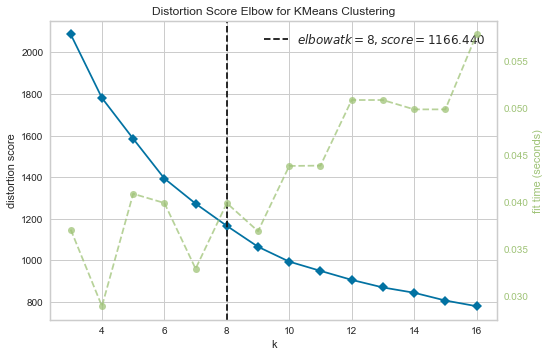

In [285]:
from yellowbrick.cluster import KElbowVisualizer

model = KMeans()
visualizer = KElbowVisualizer(model, k=(3,17))
visualizer.fit(customers_scale)
visualizer.poof()


In [286]:
# Your code here
n_clusters = 8
cluster = KMeans(n_clusters=n_clusters, random_state=0, n_jobs=-1)

# Train model
model = cluster.fit(customers_scale)

customers_d['labels'] = cluster.labels_



C:\Users\haenni\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


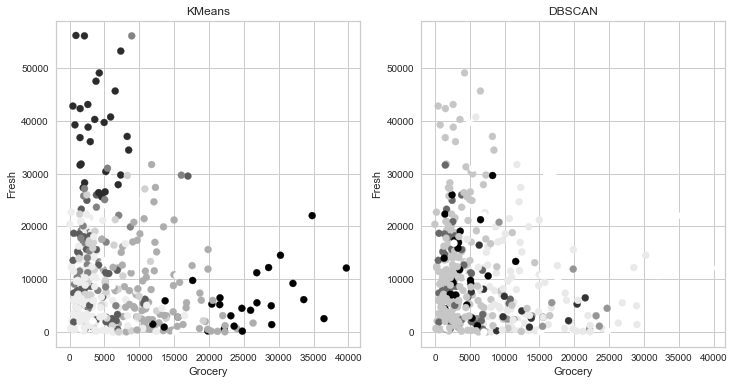

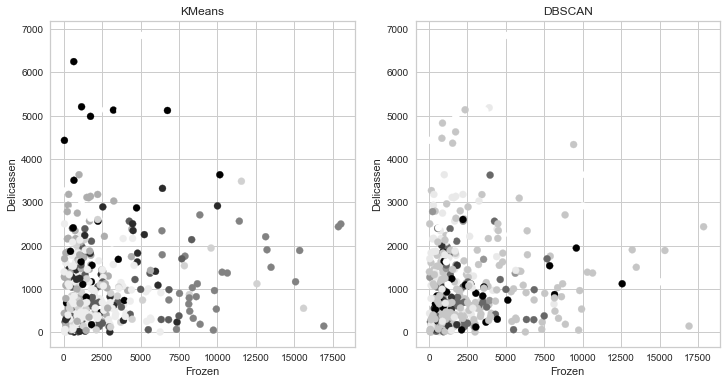

,Fresh,Milk,Grocery,Frozen,Delicassen,Channel_2,Region_2,Region_3,labels_DBSCAN
labels,,,,,,,,,
0,14741.541667,7100.250000,6880.791667,3252.458333,4132.458333,0.125000,0.00,0.833333,0.458333
1,7621.408759,2418.562044,3144.094891,1733.854015,735.744526,0.000000,0.00,1.000000,1.000000
2,10214.421053,2846.000000,5674.552632,3167.815789,960.947368,0.289474,1.00,0.000000,4.289474
3,7844.730337,7709.089888,12487.730337,1256.449438,1303.775281,1.000000,0.00,0.921348,0.157303
4,17634.517241,4255.241379,4144.000000,10469.689655,1250.068966,0.034483,0.00,0.965517,0.689655
5,9118.019231,3154.326923,3794.730769,2489.576923,854.211538,0.057692,0.00,0.000000,2.807692
6,38015.250000,3659.857143,3897.250000,3156.964286,1343.071429,0.071429,0.00,0.857143,0.678571
7,6023.440000,17449.120000,25259.400000,2168.160000,2385.640000,0.960000,0.28,0.400000,0.280000


In [287]:
# Your comment here
plotcompare('Grocery', 'Fresh')
plotcompare('Frozen', 'Delicassen')
customers_d.groupby(['labels']).mean()

### way better than before

# Bonus Challenge 2 - Changing DBSCAN `eps` and `min_samples`

Experiment changing the `eps` and `min_samples` params for DBSCAN. See how the results differ with scatter plot visualization.

C:\Users\haenni\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


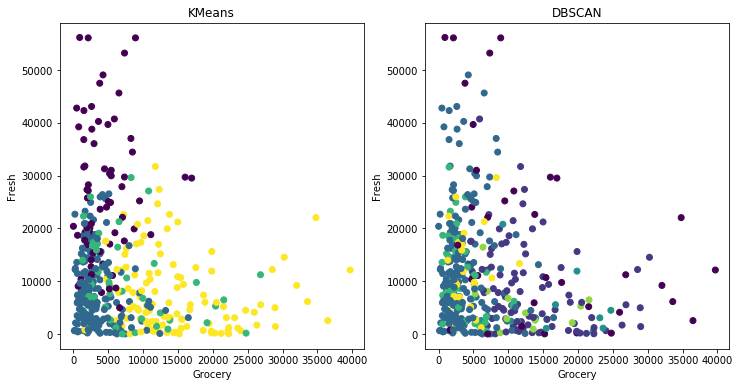

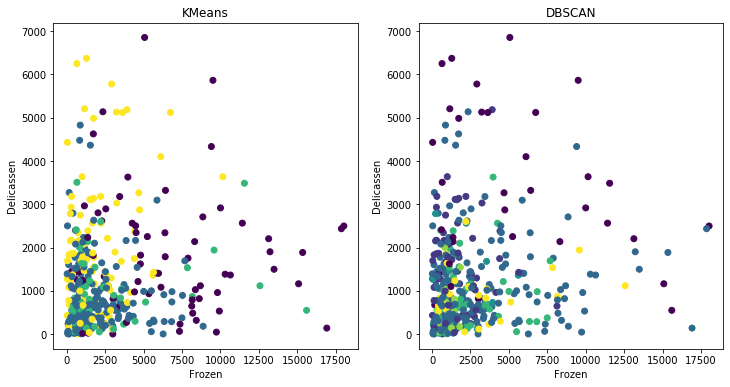

,Fresh,Milk,Grocery,Frozen,Delicassen,Channel_2,Region_2,Region_3,labels
labels_DBSCAN,,,,,,,,,
-1,19405.264706,12477.970588,14807.705882,5484.647059,3352.205882,0.529412,0.205882,0.411765,1.647059
0,8587.688889,8073.722222,13109.033333,1383.600000,1314.211111,1.000000,0.000000,1.000000,2.888889
1,11943.096447,2879.492386,3440.456853,2897.954315,1041.395939,0.000000,0.000000,1.000000,0.766497
2,4748.076923,8658.538462,15531.461538,1942.076923,1270.846154,1.000000,0.000000,0.000000,3.000000
3,9614.300000,2890.440000,3349.240000,2387.280000,873.080000,0.000000,0.000000,0.000000,0.960000
4,5284.500000,8292.166667,12349.000000,1047.916667,671.333333,1.000000,1.000000,0.000000,2.000000
5,11288.269231,1823.153846,3939.500000,3245.807692,954.076923,0.000000,1.000000,0.000000,2.000000


In [283]:
# Your code here
from sklearn.cluster import DBSCAN

# Create meanshift object
cluster = DBSCAN(eps=2, min_samples = 9 )

# Train model
model = cluster.fit(customers_scale)

customers_d['labels_DBSCAN'] = cluster.labels_


plotcompare('Grocery', 'Fresh')
plotcompare('Frozen', 'Delicassen')
customers_d.groupby(['labels_DBSCAN']).mean()

In [ ]:
# Your comment here

#the higher eps the less clusters
#the higher min_samples the less clusters

#but still it is difficult to say, wicht is the best algorithm (at least for me, in general i prefer less clusters, because it is easier to understand for me as a human, but this is not the question:-)